In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
import os

town_name = 'Belfast, Pennsylvania, USA'
map_size = 5000

file_path = town_name.replace(' ','_')
if not os.path.exists(file_path):
    os.mkdir(file_path) 

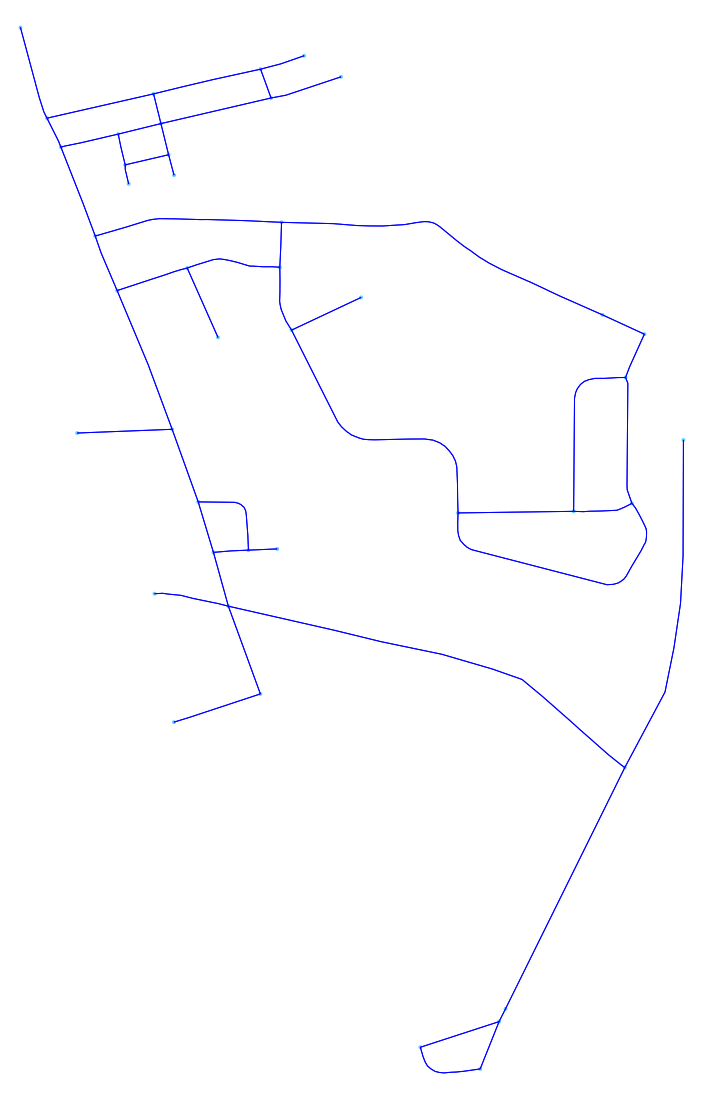

In [2]:

town = ox.graph_from_place(town_name, network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(town), edge_color='b', fig_height=20)
fig.savefig('%s/town.png' % file_path)
# here is the intial townfig.savefig('%s/test.png' % file_path)

In [3]:
# we want more than the town though, because we care about cutting it off from the outside, so we need to know about 
# the outside. For now, let's get everything within 10km of the center of town

G = None
town_nodes = ox.graph_to_gdfs(town, edges=False)
                              
# create gdf of the graph edges
gdf_edges = ox.graph_to_gdfs(town, nodes=False, fill_edge_geometry=True)
# get graph centroid
x, y = gdf_edges.unary_union.centroid.xy
graph_centroid = (y[0], x[0])
G = ox.graph_from_point(graph_centroid, distance=map_size,  network_type='drive')

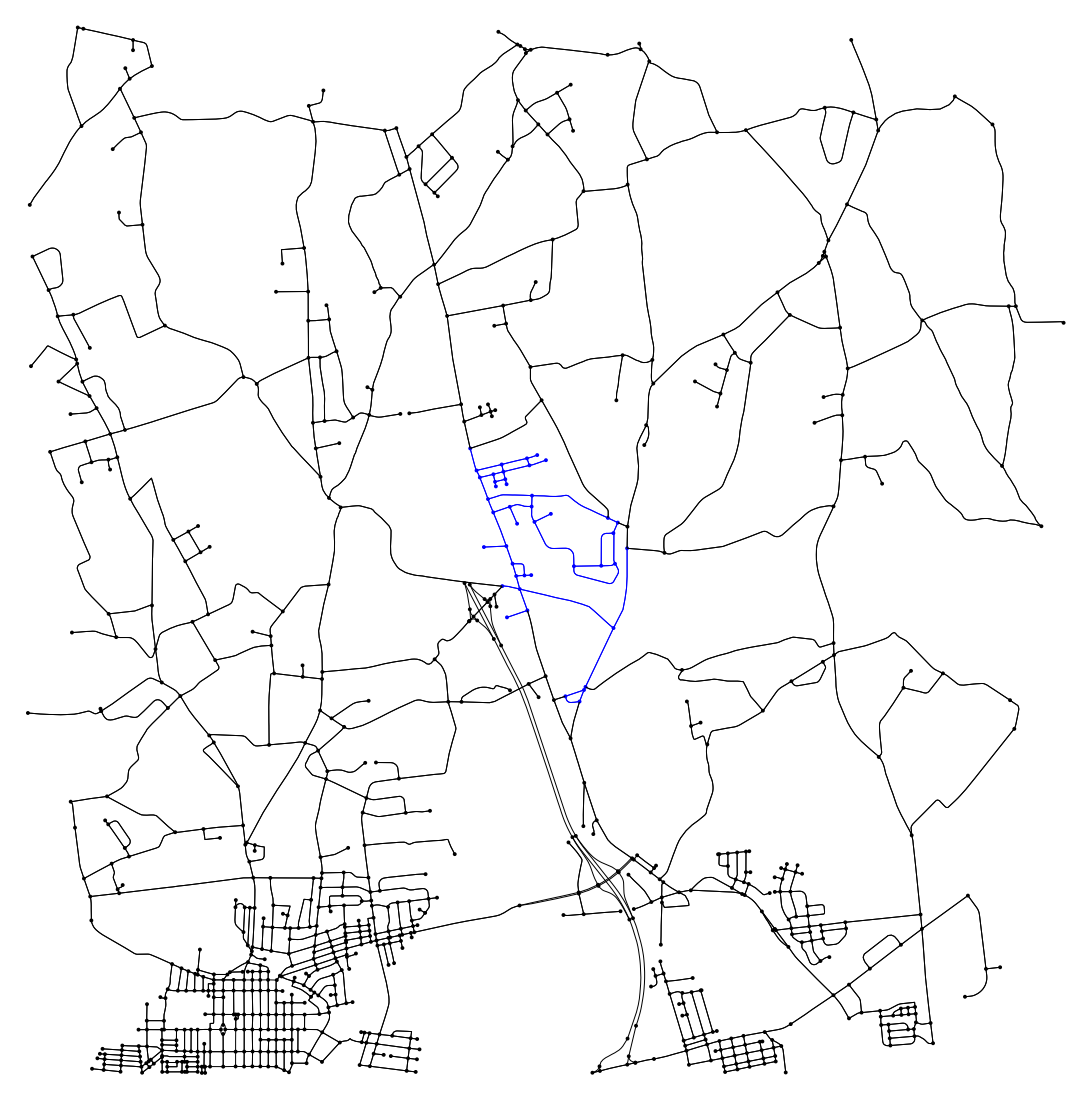

In [4]:
nc = ['b' if node in town else 'k' for node in G.nodes()]
ec = ['b' if e in town.edges() else 'k' for e in G.edges()]
fig, ax = ox.plot_graph(G, node_color=nc, edge_color=ec, fig_height=20)
fig.savefig('%s/area.pdf' % file_path)
# blue is the town


In [5]:
# so now that we have the graph, let's see how to cut it off
# Task 1: isolate the town!
# psudo code:
# for every node in the town
    # if it has an edge to something outside the town:
        # color that edge red!

# we're working with dataframes though, so we're not gonna use loops here and instead leverage the data structure
nodes, edges = ox.graph_to_gdfs(G)

town_node_ids = set(town.nodes())

edges['v_in_town'] = edges['v'].isin(town_node_ids)
edges['u_in_town'] = edges['u'].isin(town_node_ids)
edges['in_town'] = edges['v_in_town'] & edges['u_in_town']
edges['block'] = (edges['v_in_town'] & ~ edges['u_in_town']) | (edges['u_in_town'] & ~ edges['v_in_town'])

conditions = [(edges['block']), (edges['in_town'])]
choices = ['r', 'b']
edges['edge_color'] = np.select(conditions, choices, default='k')
print('number of edges to block: %d' % (edges['edge_color'].value_counts()['r']))


number of edges to block: 24


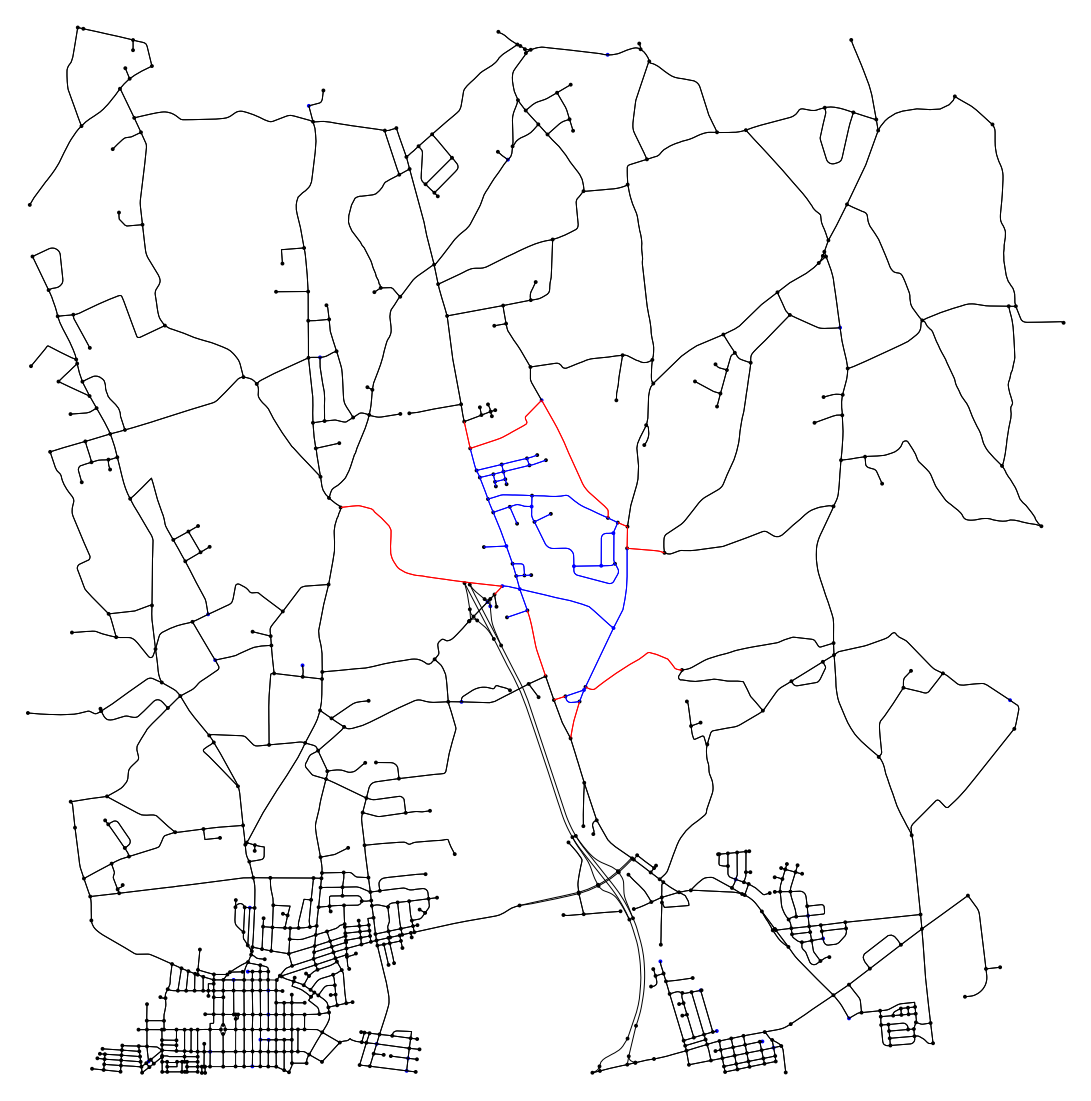

In [6]:
nc = ['b' if node in town else 'k' for node in G.nodes()]
G = ox.gdfs_to_graph(nodes, edges)
nodes, edges = ox.graph_to_gdfs(G)
fig, ax = ox.plot_graph(G, edge_color=edges['edge_color'], node_color=nc, fig_height=20)
fig.savefig('%s/isolate.pdf' % file_path, dpi=1000, format='pdf')